### Analysis of The COVID Tracking Project Numbers
- Twitter: @COVID19Tracking
- Interest primarily in how hospitalizations have changed over time
- Around 25% of those that are hospitalized end up dying

In [14]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams
from state_config import state_conversion

sns.set()
rcParams['font.family'] = 'DejaVu Sans'
pd.options.display.max_columns = 50
pd.options.display.max_rows = 50

In [15]:
# data = pd.read_csv('../data/tctp.csv')
us_populations = pd.read_csv('../data/us_populations.csv')
us_populations.rename(columns={'Geographic Area': 'full_name'}, inplace=True)
data = pd.read_csv('https://covidtracking.com/api/v1/states/daily.csv')

# Reformat
date_columns = ['date', 'lastUpdateEt', 'dateChecked']
for column in date_columns:
    if column == 'date':
        data[column] = pd.to_datetime(data[column], format='%Y%m%d')
    else:
        data[column] = pd.to_datetime(data[column])
        
# Keep only states and datapoints after certain point in time
data = data[data['date'] > '2020-04-01']
data = data[data['state'].isin(state_conversion.keys())]
data.sort_values('date', ascending=True, inplace=True)

# Look at only data of interest
columns = ['state', 'date', 'hospitalizedIncrease', 'hospitalizedCurrently', 'hospitalizedCumulative', 'positive', 'negative', 'deathIncrease']
data = data.loc[:, columns]

# New features
data['positivity_rate'] = data['positive'] / (data['positive'] + data['negative'])
data['full_name'] = data['state'].map(state_conversion)
data = data.merge(us_populations, how='left', on='full_name')
data['deaths_per_million'] = data['deathIncrease'] / data['Population'] * 1000000
data['hospitalizations_per_million'] = data['hospitalizedCurrently'] / data['Population'] * 1000000

print(data.shape)
data.head()

(5500, 13)


,state,date,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,positive,negative,deathIncrease,positivity_rate,full_name,Population,deaths_per_million,hospitalizations_per_million
0,WY,2020-04-02,1,NaN,19.0,150.0,2439.0,0,0.057937,Wyoming,578759,0.000000,NaN
1,MI,2020-04-02,0,NaN,NaN,21376.0,33443.0,125,0.389938,Michigan,9986857,12.516450,NaN
2,ME,2020-04-02,5,NaN,68.0,376.0,6088.0,0,0.058168,Maine,1344212,0.000000,NaN
3,MD,2020-04-02,60,NaN,582.0,2331.0,18890.0,12,0.109844,Maryland,6045680,1.984888,NaN
4,MA,2020-04-02,131,NaN,813.0,8867.0,47767.0,42,0.156567,Massachusetts,6892503,6.093577,NaN


Notes:
- `hospitalizedCurrently` should be the primary metric of interest. Should want to know if the number of hospitalizations has been increasing. For cases where hospitalized currently is not available, `hospitazliedCumulative` should be used. Should split these two groups.
- **Nebraska started to provide hospitalization data on June 3

In [ ]:
# States with hospitazliedCurrently data
hosp_curr_states = [
    'AK', 'AL', 'AR', 'AZ', 'CA', 'CO', 
    'CT', 'DE', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 
    'KY', 'LA', 'MA', 'MD', 'ME', 
    'MI', 'MN', 'MO', 'MS', 'MT',
    'NC', 'ND', 'NE', 'NH', 'NJ', 'NM',
    'NV', 'NY', 'OH', 'OK', 'OR', 
    'PA', 'RI', 'SC', 'SD', 'TN', 'TX', 'UT', 
    'VA', 'VT', 'WA', 'WI', 'WV', 'WY'
]
hosp_cum_states = ['HI', 'KS',]

### Currently Hospitalizated

In [ ]:
# Get states with currently hospitalized data
temp = (
    data[data['state'].isin(hosp_curr_states)]
    .sort_values(['state', 'date'], ascending=True)
    .fillna(method='bfill')   
)

# Rolling features
temp['deaths_rolling_mean'] = temp.groupby('state')['deaths_per_million'].transform(lambda x: x.rolling(7).mean())
temp['hospitalizations_rolling_mean'] = temp.groupby('state')['hospitalizations_per_million'].transform(lambda x: x.rolling(7).mean())
temp['pr_rolling_mean'] = temp.groupby('state')['positivity_rate'].transform(lambda x: x.rolling(7).mean())

temp.tail()

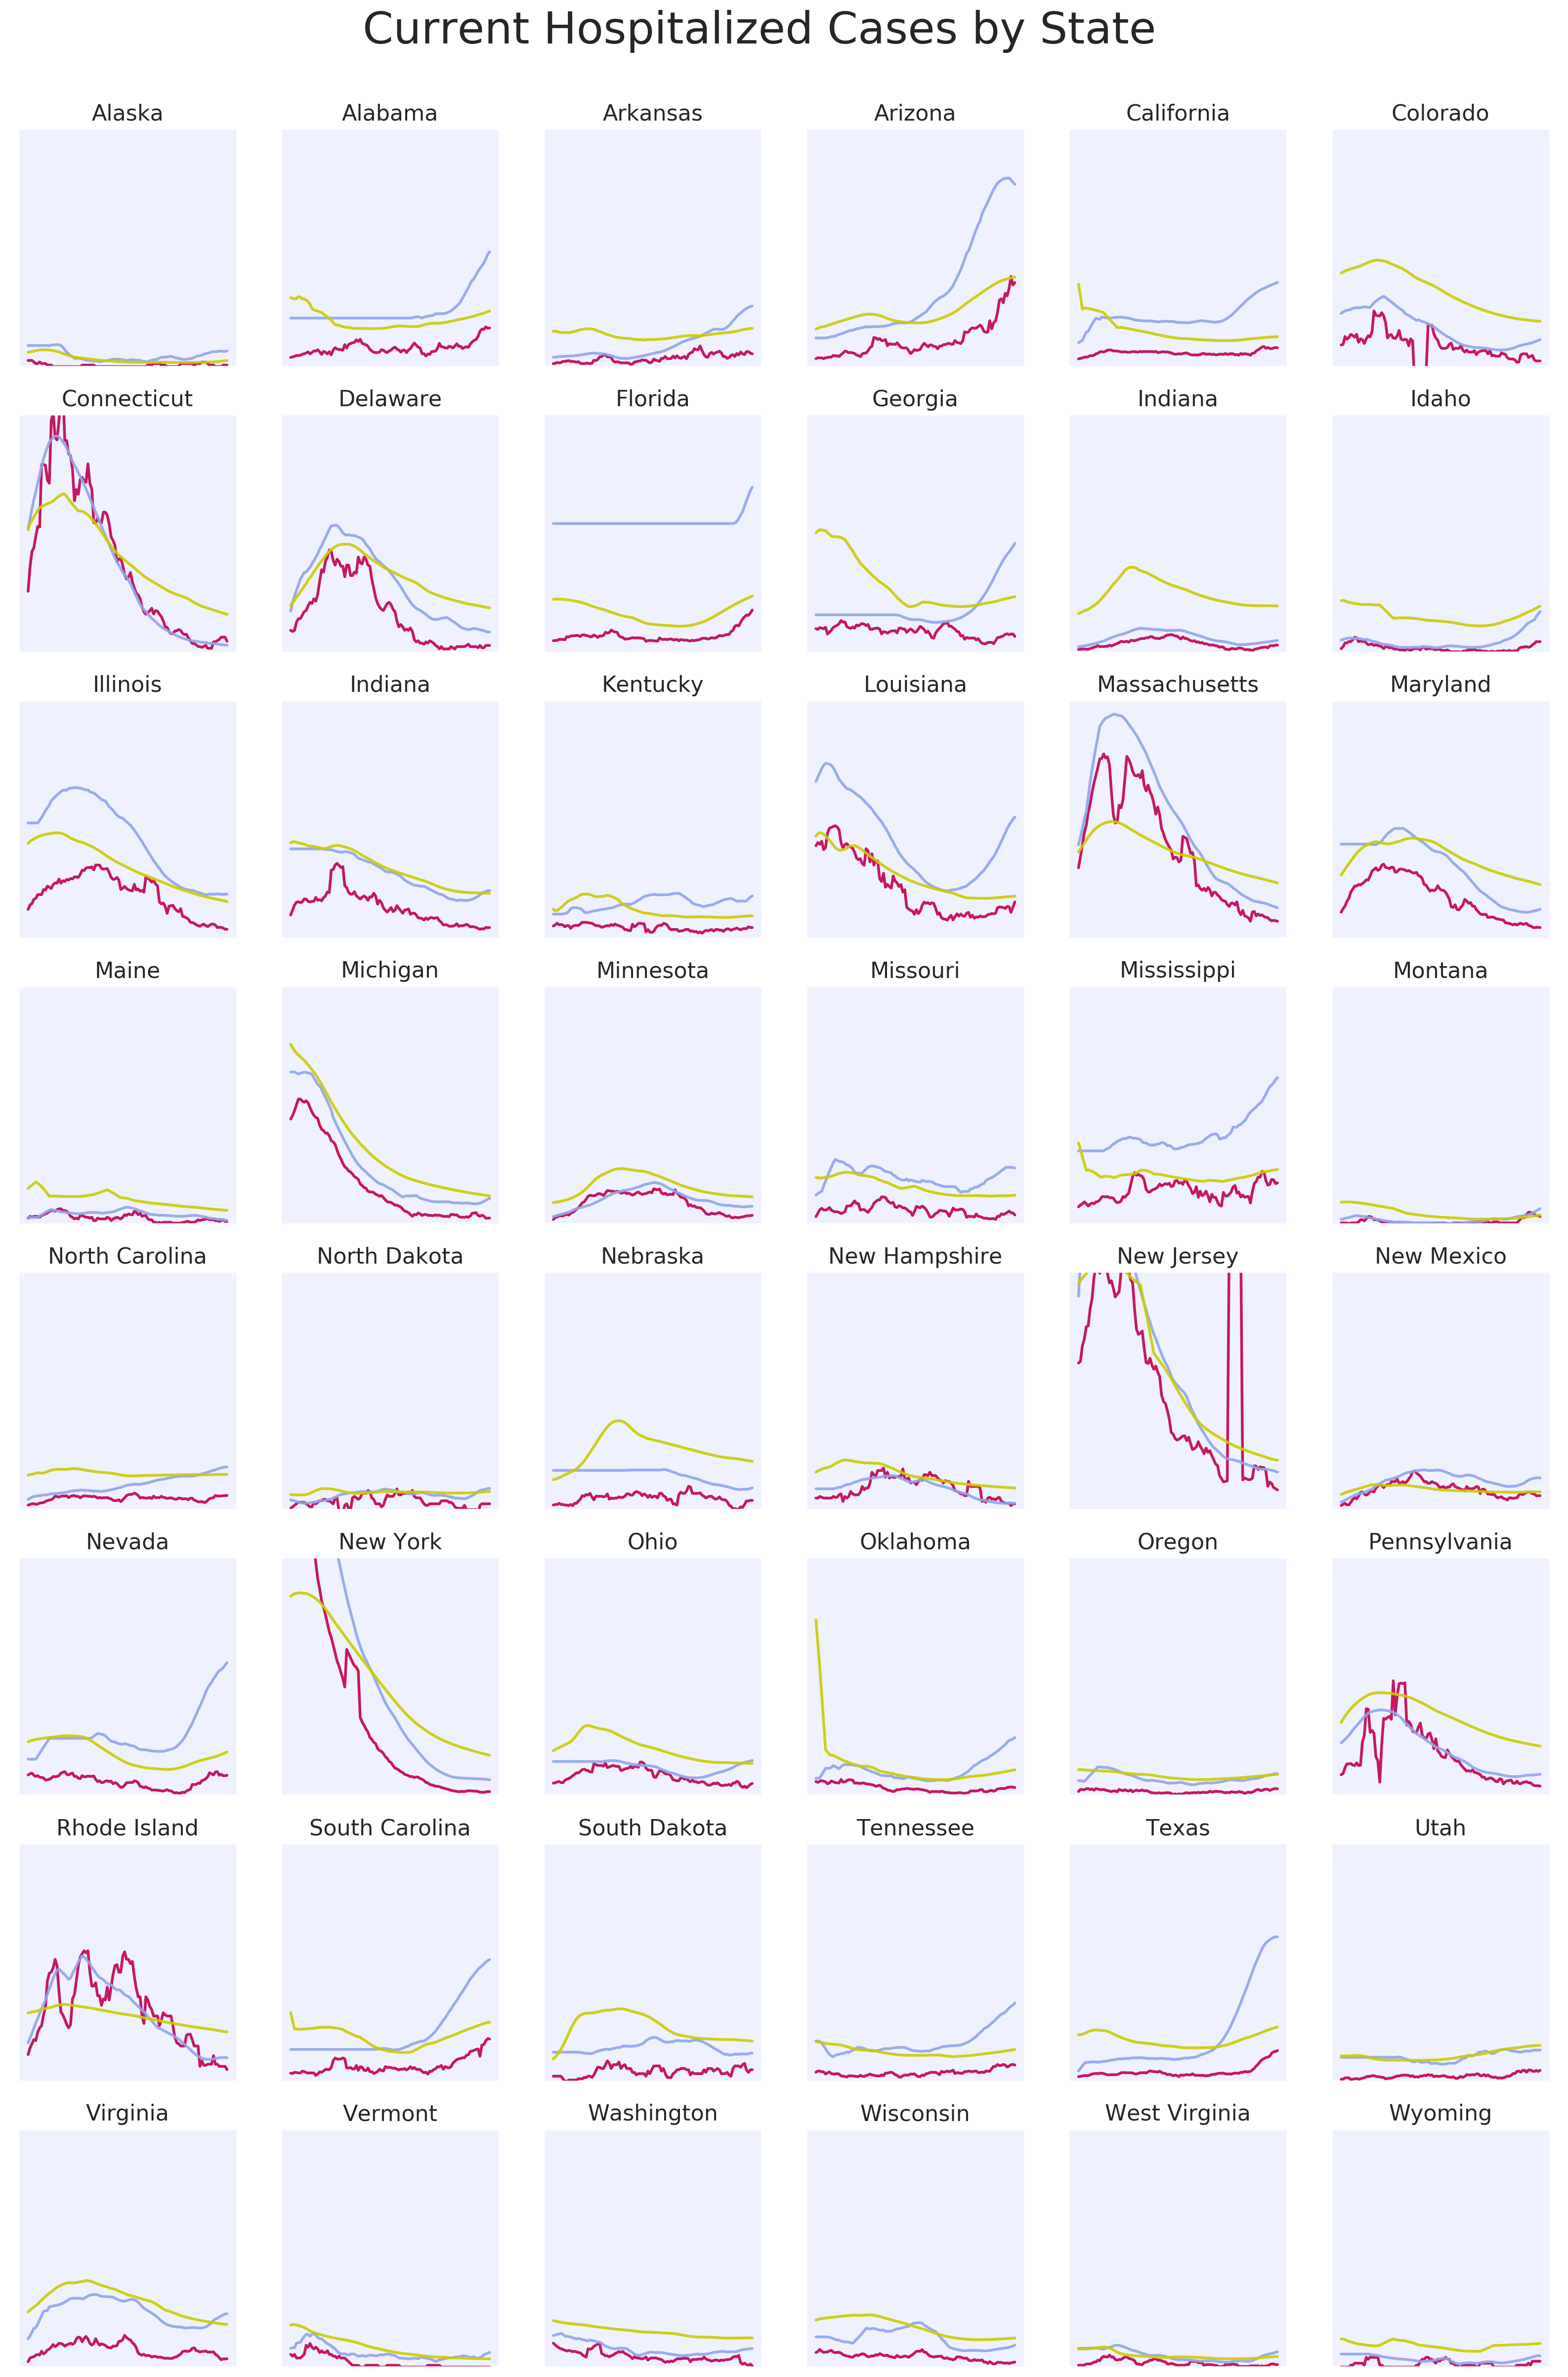

In [6]:
def dual_axes_plot(df, feature1, feature2, feature3):
    
    # Get all states and dates
    states = df['state'].unique()
    dates = df['date'].unique()

    fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(20,30), dpi=200)
    fig.suptitle('Current Hospitalized Cases by State', fontsize=32, y=0.92)

    for index, ax in enumerate(axes.flatten()):

        # Isolate state
        state = states[index]
        state_name = state_conversion[state]
        state_df = df[df['state'] == state]

        # Plot parameters
        ax.set_title(state_name, fontsize=16)
        ax.set_facecolor('#EFF2FE')
        ax.xaxis.grid(False)

        # Plot: dual axes line plot; ;)
        ax.plot(dates, state_df[feature1], c='#C20051', alpha=0.9, linewidth=2.0)
        ax2 = ax.twinx()
        ax2.plot(dates, state_df[feature2], c='#90A5ED', alpha=0.9, linewidth=2.0)
        ax3 = ax2.twinx()
        ax3.plot(dates, state_df[feature3], c='#cccc00', alpha=0.9, linewidth=2.0)
        
        # Set y-axis limits
        ax.set_ylim(0, 30)
        ax2.set_ylim(0, 600)
        ax3.set_ylim(0, 0.48)
        
        # Remove tick notation
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)

    plt.savefig('../images/hosp_deaths_pos.png', dpi=200, bbox_inches='tight')
    plt.show()
    
dual_axes_plot(temp, 'deaths_rolling_mean', 'hospitalizations_rolling_mean', 'pr_rolling_mean')

In [21]:
# Get all states and dates
states = temp['state'].unique()
dates = temp['date'].unique()

In [20]:
date = '2020-07-20'
hospitalizations = 300
condition = (temp['date'] == date) & (temp['hospitalizations_per_million'] > hospitalizations)
temp[condition]

,state,date,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,positive,negative,deathIncrease,positivity_rate,full_name,Population,deaths_per_million,hospitalizations_per_million,deaths_rolling_mean,hospitalizations_rolling_mean,pr_rolling_mean
5460,AL,2020-07-20,586,1563.0,8368.0,68891.0,524897.0,4,0.116020,Alabama,4903185,0.815796,318.772390,4.865642,289.520267,0.112041
5469,AZ,2020-07-20,66,3084.0,6698.0,145183.0,648340.0,23,0.182960,Arizona,7278717,3.159898,423.701045,10.578787,459.029092,0.180762
5464,FL,2020-07-20,296,9489.0,21605.0,360394.0,2691712.0,92,0.118080,Florida,21477737,4.283505,441.806323,5.334427,416.644055,0.113494
5455,LA,2020-07-20,0,1508.0,813.0,94892.0,1008032.0,29,0.086037,Louisiana,4648794,6.238177,324.385206,4.578760,305.301916,0.084849
5473,MS,2020-07-20,39,1119.0,3766.0,43889.0,346086.0,3,0.112543,Mississippi,2976149,1.008014,375.989240,5.184072,368.405134,0.110112
5492,NV,2020-07-20,0,1086.0,22786.0,36713.0,358708.0,1,0.092845,Nevada,3080156,0.324659,352.579545,2.550891,334.955205,0.087849
5487,SC,2020-07-20,0,1593.0,4182.0,71445.0,516871.0,9,0.121440,South Carolina,5148714,1.748009,309.397648,5.327266,306.872745,0.119436
5483,TX,2020-07-20,0,10569.0,100.0,332434.0,2652120.0,62,0.111385,Texas,28995881,2.138235,364.500047,3.867544,364.327609,0.109465


48


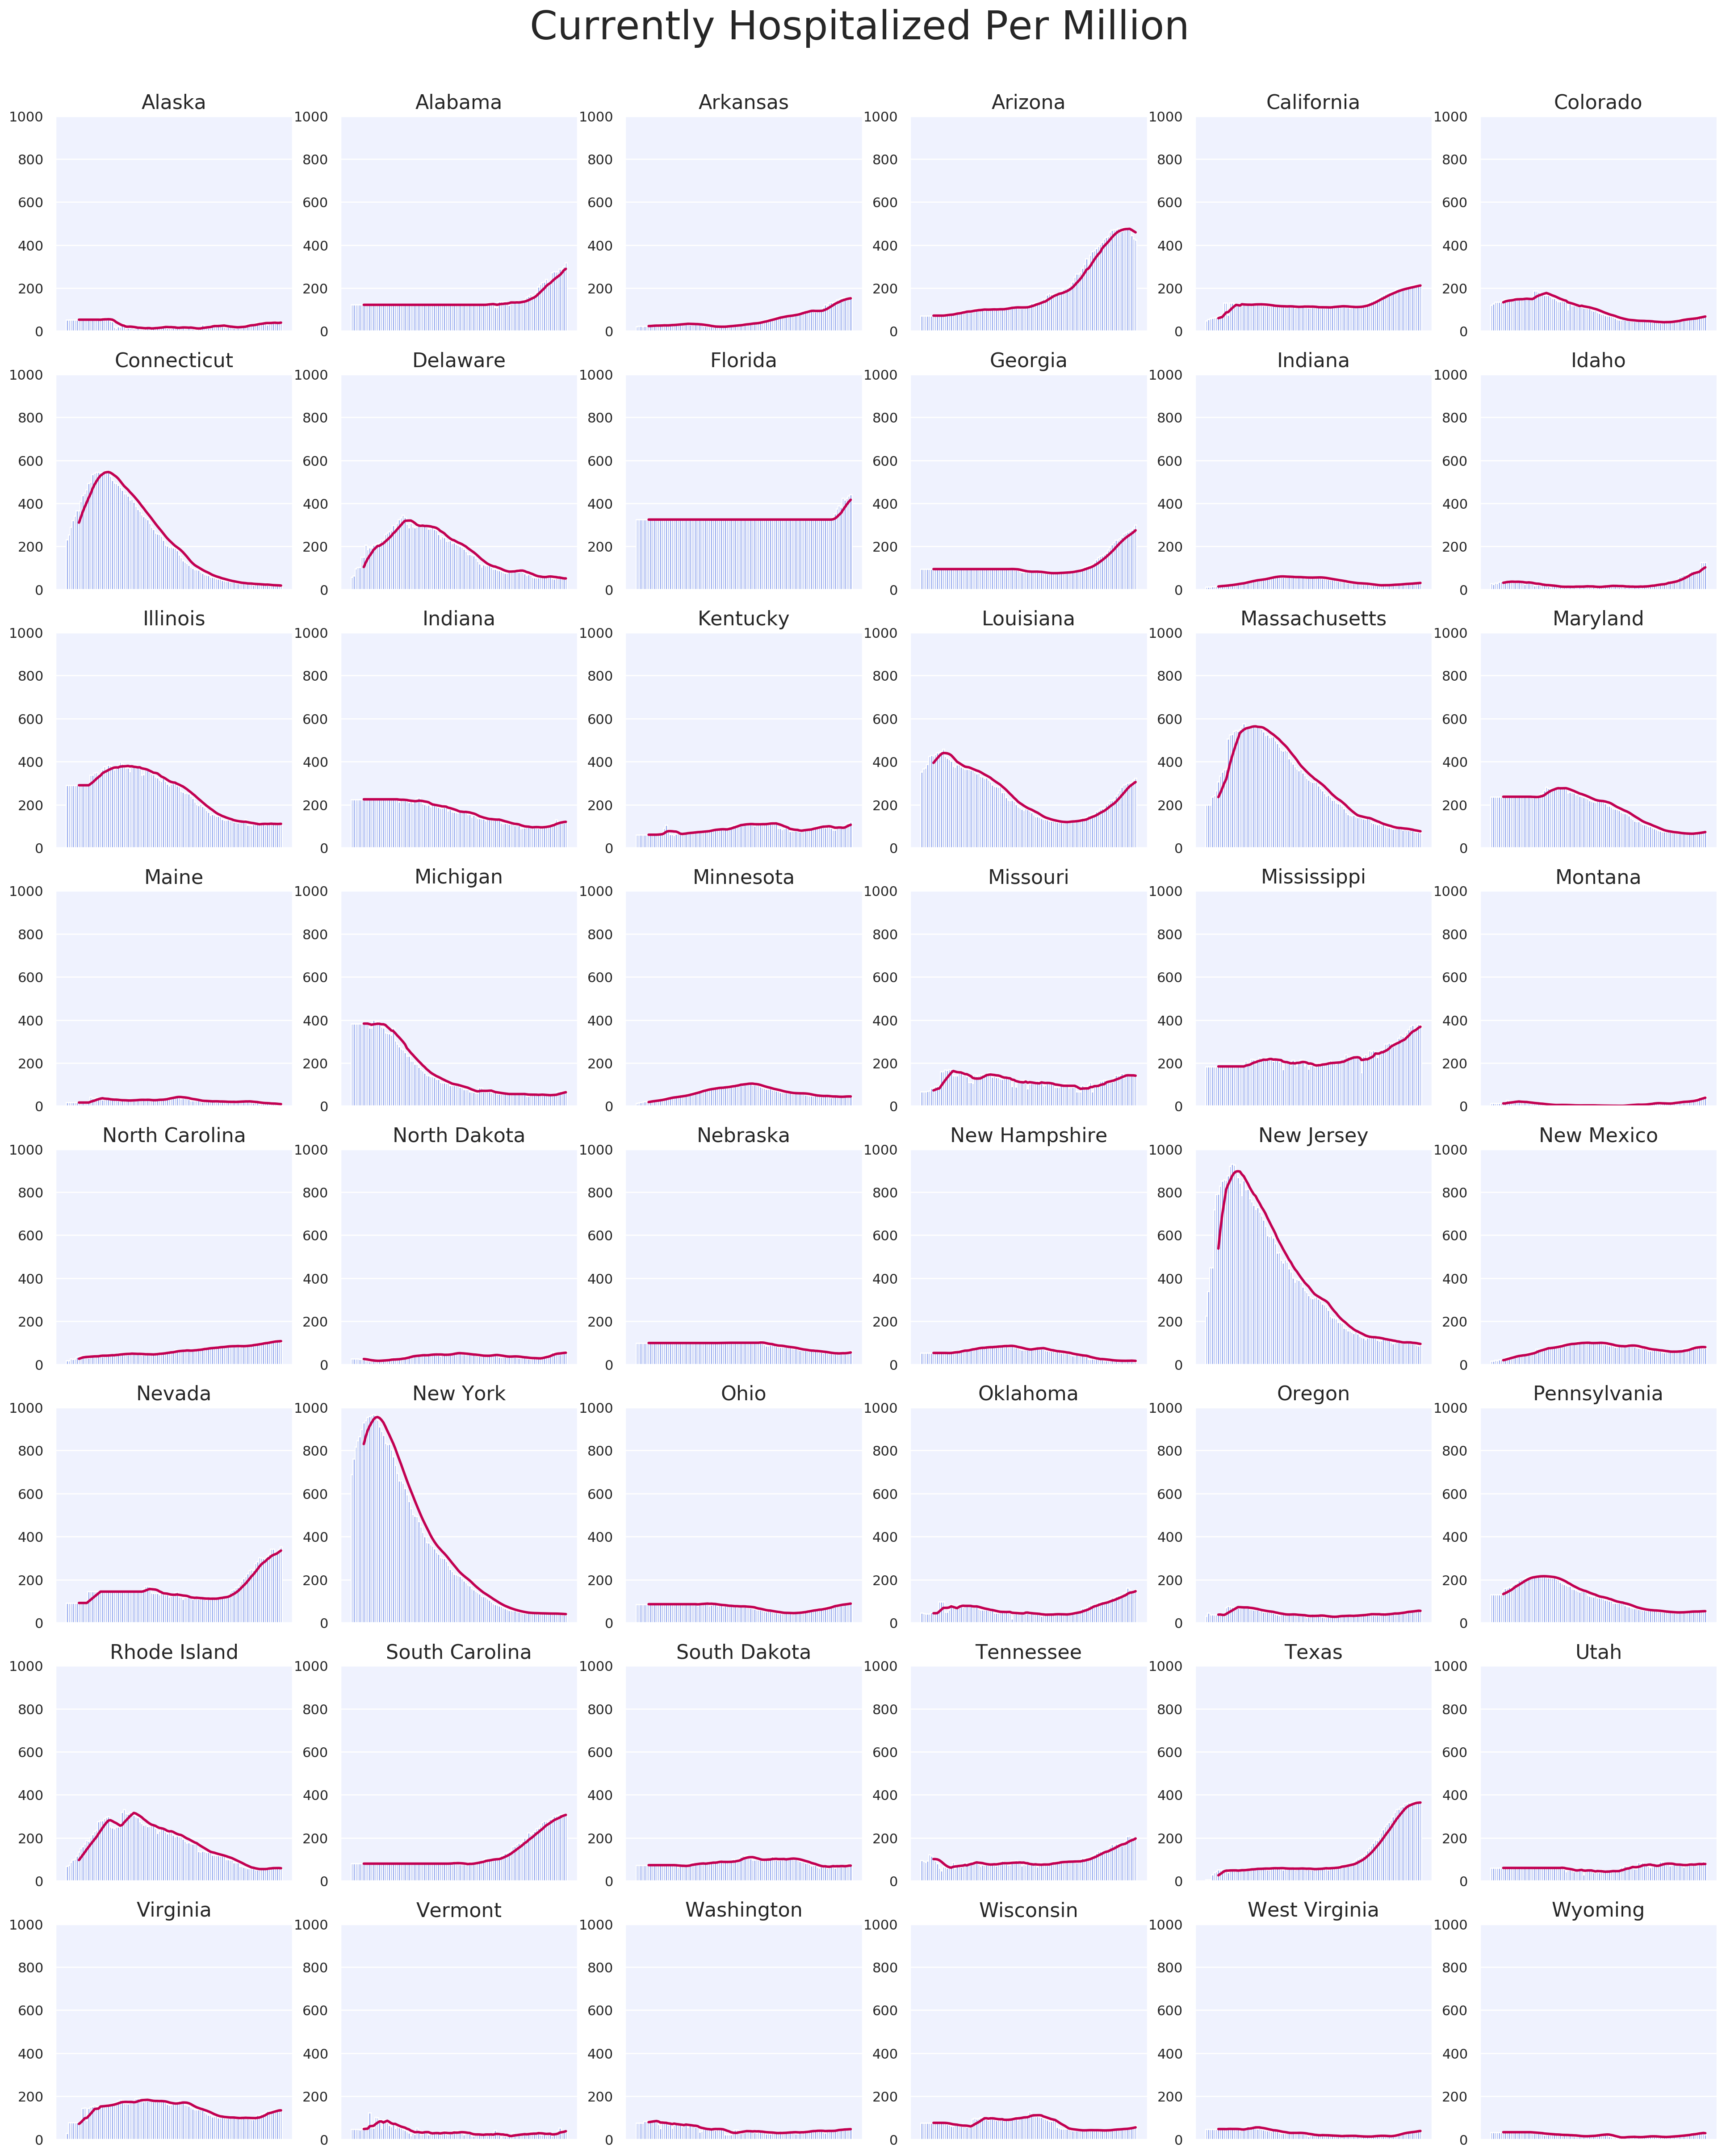

In [22]:
def counts_chart(df, states, dates, feature):
    '''Plot distribution of case counts and the rolling average'''
    
    print(len(states))

    fig, axes = plt.subplots(nrows=8, ncols=6, figsize=(24,30), dpi=200)
    fig.suptitle('Currently Hospitalized Per Million', fontsize=32, y=0.92)

    for index, ax in enumerate(axes.flatten()):

        # Isolate state
        state = states[index]
        state_name = state_conversion[state]
        state_df = df[df['state'] == state]

        # Plot parameters
        ax.set_title(state_name, fontsize=16)
        ax.set_facecolor('#EFF2FE')
        ax.set_ylim(0, 1000)
        ax.tick_params(labelbottom=False)
        ax.xaxis.grid(False)

        # Plot: Distribution of counts per day
        ax.bar(dates, state_df[feature], color='#90A5ED', alpha=1.0, width=1.0)

        # Plot: Rolling Average
        ax.plot(dates, state_df['hospitalizations_rolling_mean'], c='#C20051', alpha=1.0, linewidth=2.0)
        

    plt.savefig('../images/hospitalized_cases.png', dpi=200, bbox_inches='tight')
    plt.show()
    
counts_chart(temp, states, dates, 'hospitalizations_per_million')
# counts_chart(temp, states, dates, 'positivity_rate')

### Cumulative Hospital Counts

In [9]:
# Get states with cummulative hospital counts
temp = (
    data[data['state'].isin(hosp_cum_states)]
    .sort_values(['state', 'date'], ascending=True)
    .fillna(method='bfill')   
)

temp['hospitalizedIncrease_rolling_mean'] = temp.groupby('state')['hospitalizedIncrease'].transform(lambda x: x.rolling(7).mean())

temp.head()

,state,date,hospitalizedIncrease,hospitalizedCurrently,hospitalizedCumulative,positive,negative,deathIncrease,positivity_rate,full_name,Population,deaths_per_million,hospitalizations_per_million,hospitalizedIncrease_rolling_mean
23,HI,2020-04-02,2,NaN,15.0,258.0,10206.0,0,0.024656,Hawaii,1415872,0.000000,NaN,NaN
72,HI,2020-04-03,0,NaN,15.0,285.0,10206.0,1,0.027166,Hawaii,1415872,0.706279,NaN,NaN
122,HI,2020-04-04,3,NaN,18.0,319.0,11959.0,1,0.025981,Hawaii,1415872,0.706279,NaN,NaN
172,HI,2020-04-05,1,NaN,19.0,351.0,12604.0,1,0.027094,Hawaii,1415872,0.706279,NaN,NaN
222,HI,2020-04-06,2,NaN,21.0,371.0,13155.0,0,0.027429,Hawaii,1415872,0.000000,NaN,NaN


In [10]:
# Get all states and dates
states = temp['state'].unique()
dates = temp['date'].unique()

IndexError: index 2 is out of bounds for axis 0 with size 2

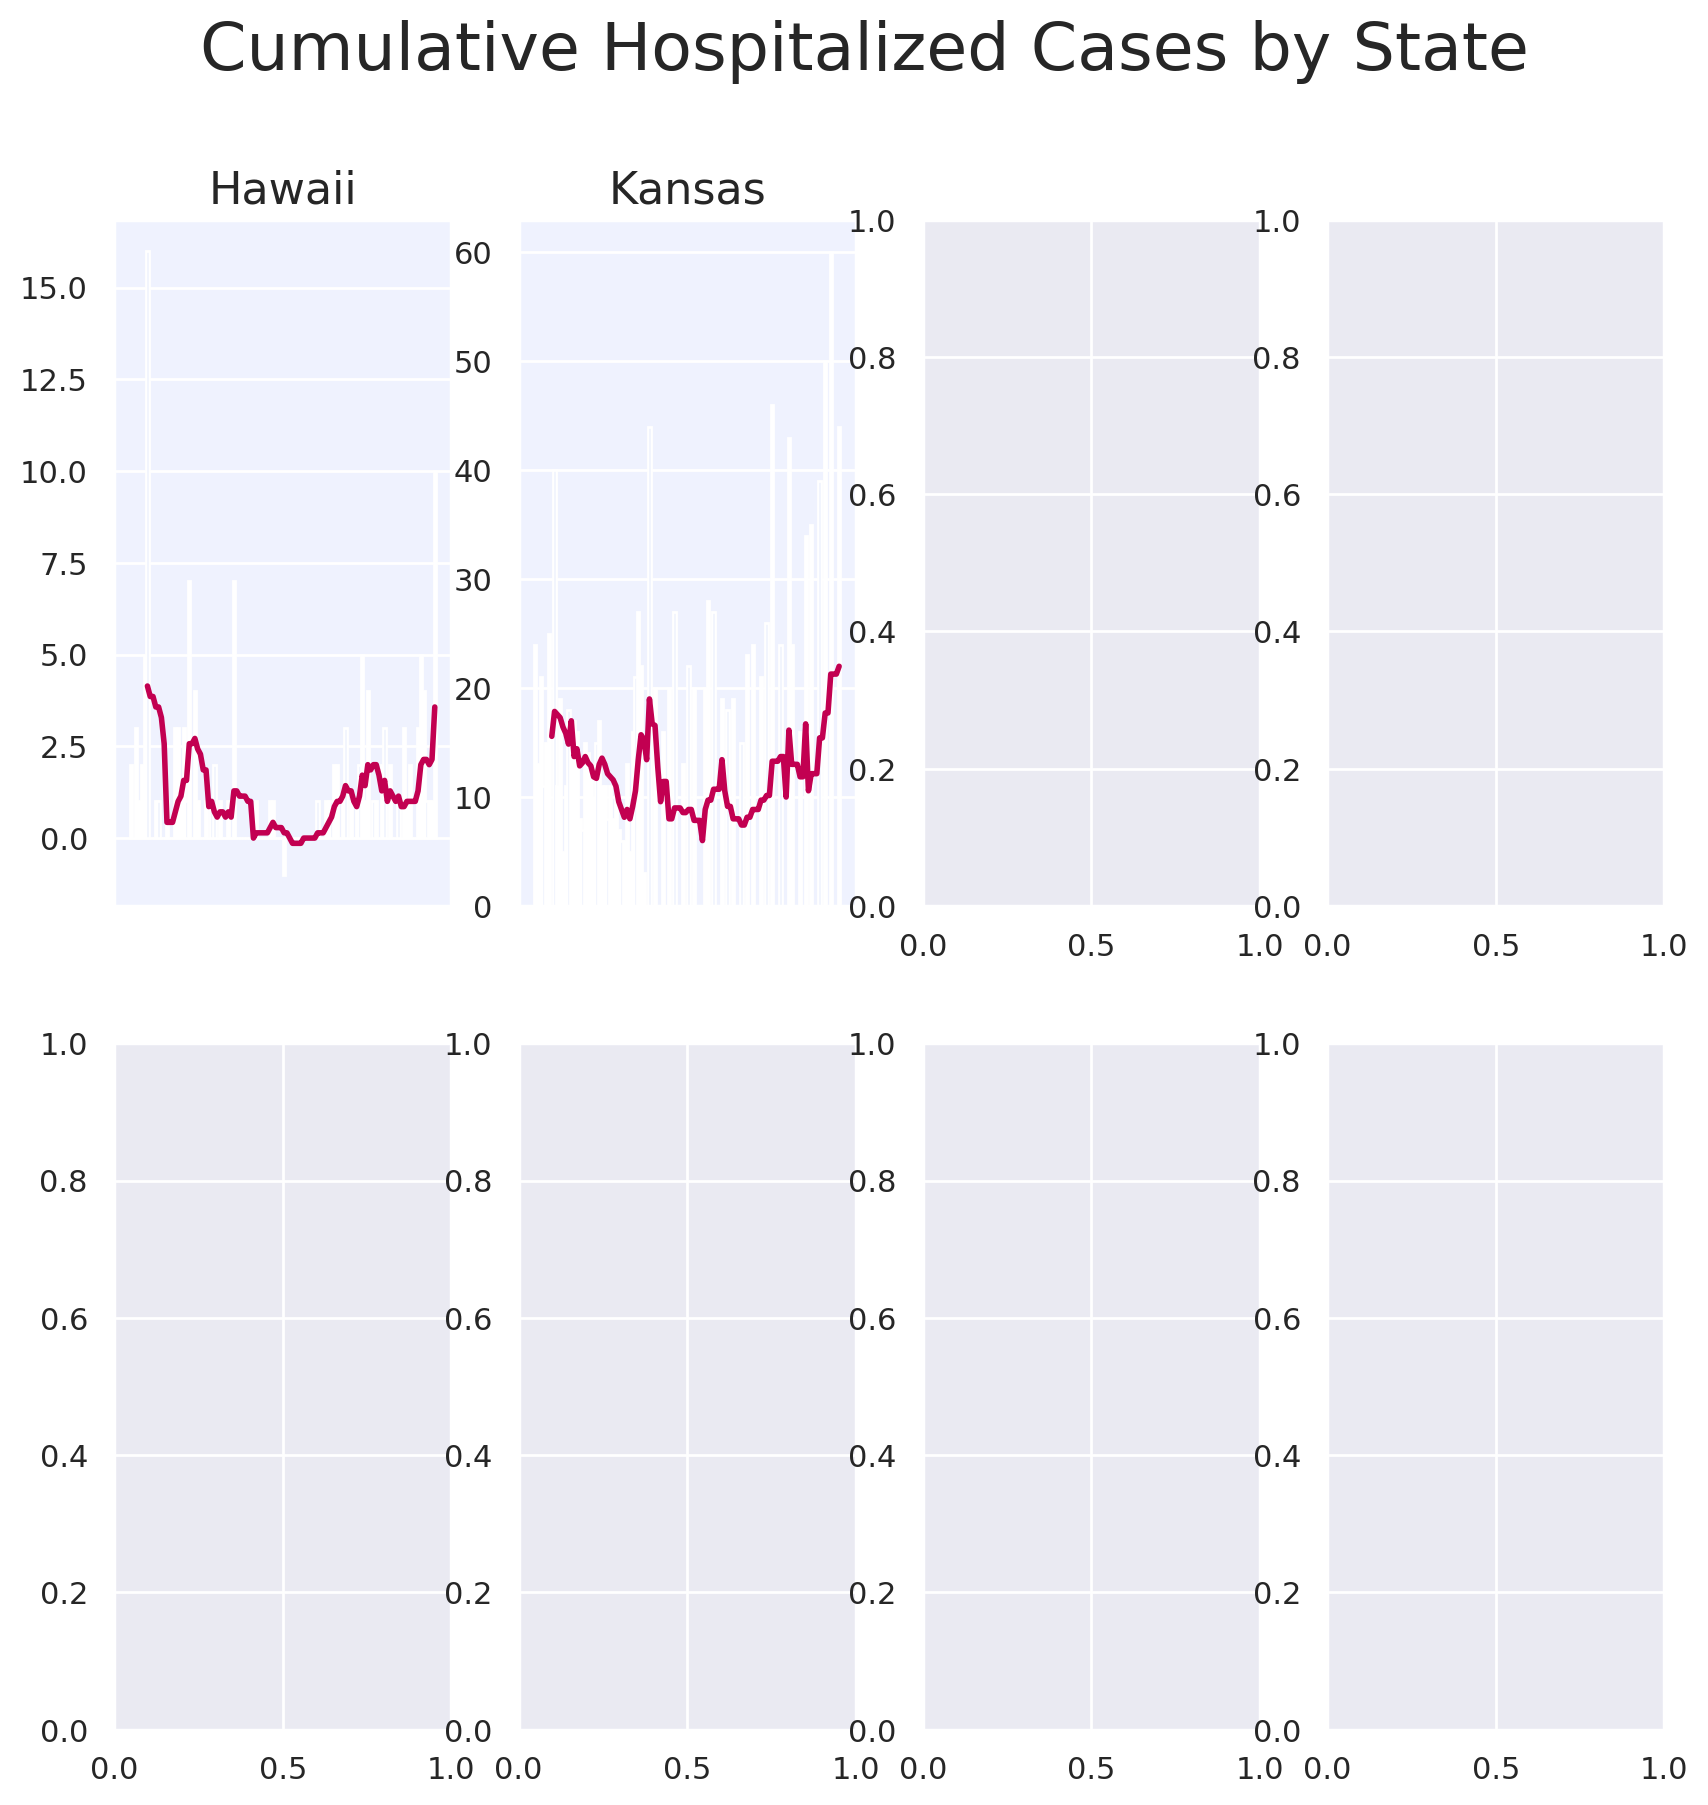

In [11]:
def counts_chart(df, states, dates):
    '''Plot distribution of case counts and the rolling average'''

    fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(10,10), dpi=200)
    fig.suptitle('Cumulative Hospitalized Cases by State', fontsize=24)

    for index, ax in enumerate(axes.flatten()):

        # Isolate state
        state = states[index]
        state_name = state_conversion[state]
        state_df = df[df['state'] == state]

        # Plot parameters
        ax.set_facecolor('#EFF2FE')
        ax.tick_params(labelbottom=False)
        ax.xaxis.grid(False)
        ax.set_title(state_name, fontsize=16)

        # Plot: Distribution of counts per day
        ax.bar(dates, state_df['hospitalizedIncrease'], color='#90A5ED', alpha=1.0, width=0.8)

        # Plot: Rolling Average
        ax.plot(dates, state_df['hospitalizedIncrease_rolling_mean'], c='#C20051', alpha=1.0, linewidth=2.0)


    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig('../images/hospitalized_cases-cumulative.png')
    plt.show()
    
counts_chart(temp, states, dates)